<a href="https://colab.research.google.com/github/chitra-psg/rossmann_sales_prediction/blob/main/Rossman_Sales_Prediction_SUBMISSION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Rossman Sales Forecasting**

***Problem*** : Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks.As expected, store sales are influenced by many factors, including promotional campaigns, competition, state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied.

*Build a forecasting model to forecast the daily sales for the next six weeks*

In [ ]:
!pip install pmdarima

  Using cached pmdarima-2.0.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)


In [ ]:
#importing important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import scatter_matrix
from pylab import rcParams
import statsmodels.api as sm
from scipy.stats import boxcox
import pmdarima as pm
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def plot_store_trend(title, xaxis, yaxis, chart_type,order_list =None):

  # PROMO
  fig, axis = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(10,6))
  fig.suptitle(title)
  fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

  i = 0
  for x in range (0,3):
      for y in range (0,3):
          #i = x + y + int(incr)
          j = index[i]
          label =  label_dfs[i]
          d = store_dfs[i]
          axis[x,y].title.set_text(label)
          if chart_type == 'bar':
            if order_list is None:
              sns.barplot(x=xaxis, y=yaxis, data=d, ax=axis[x,y], palette="Dark2")
            else:
              sns.barplot(x=xaxis, y=yaxis, data=d, ax=axis[x,y], order = order_list, palette="Dark2")

          if chart_type == 'line':
              sns.lineplot(x=xaxis, y=yaxis, data=d, ax=axis[x,y], palette="Dark2")
          elif chart_type == 'box':
              sns.boxplot(x=d[xaxis],whis=1.5, palette="Dark2")
          i = i + 1

In [ ]:
def calculate_metrics(variable, actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted)).round(2)

    mape = np.round(np.mean(np.abs(actual - predicted) / actual) * 100, 2)

    return rmse, mape

def add_to_model_comparison(model_comparison, model, variable, actual, predicted):
    rmse, mape = calculate_metrics(variable, actual, predicted)

    append = pd.DataFrame({
        'Model': [model],
        'Variable': [variable],
        'RMSE': [rmse],
        'MAPE': [mape]
    })

    return model_comparison.append(append, ignore_index=True)

In [ ]:
def plot_time_series(train, test, predictions, variable, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(train[variable], label='Train')
    plt.plot(test[variable], label='Test')
    plt.plot(predictions[variable], label=model_name)
    plt.legend(loc='best')
    plt.title(f'{model_name} Model - {variable}')
    plt.show()

In [ ]:
# ADF Test
def adf_test(series, name):
    result = adfuller(series)
    print(f'ADF Test for {name}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')
    is_stationary = result[1] <= 0.05
    print('Is Stationary:', is_stationary)
    print()
    return is_stationary

# KPSS Test
def kpss_test(series, name):
    result = kpss(series)
    print(f'KPSS Test for {name}:')
    print(f'KPSS Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[3]}')
    is_stationary = result[1] > 0.05
    print('Is Stationary:', is_stationary)
    print()
    return is_stationary  # Return True if stationary, False if non-stationary

## **Data Processing**

### **Source Data**

In [ ]:
store = pd.read_csv('store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
sales = pd.read_csv('train.csv')
sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
store_sales_full = sales.merge(right=store, on='Store', how='left')
store_sales_full.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
store_sales_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [ ]:
store_sales  = store_sales_full[~((store_sales_full.Open==0) & (store_sales_full.Sales==0))]

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844392 non-null  int64  
 1   DayOfWeek                  844392 non-null  int64  
 2   Date                       844392 non-null  object 
 3   Sales                      844392 non-null  int64  
 4   Customers                  844392 non-null  int64  
 5   Open                       844392 non-null  int64  
 6   Promo                      844392 non-null  int64  
 7   StateHoliday               844392 non-null  object 
 8   SchoolHoliday              844392 non-null  int64  
 9   StoreType                  844392 non-null  object 
 10  Assortment                 844392 non-null  object 
 11  CompetitionDistance        842206 non-null  float64
 12  CompetitionOpenSinceMonth  575773 non-null  float64
 13  CompetitionOpenSinceYear   5

In [ ]:
#Check nulls for null treatment
store_sales.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268619
CompetitionOpenSinceYear     268619
Promo2                            0
Promo2SinceWeek              423307
Promo2SinceYear              423307
PromoInterval                423307
dtype: int64

In [ ]:
#Competition Details
store_sales[((~ store_sales['CompetitionDistance'].isna()) & store_sales['CompetitionOpenSinceMonth'].isna())]
# Although distance is available but no start date avaialble

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,5,2015-07-31,8959,962,1,1,0,1,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,5,2015-07-31,8821,568,1,1,0,0,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,5,2015-07-31,10231,979,1,1,0,1,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,5,2015-07-31,8234,718,1,1,0,1,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,5,2015-07-31,6566,633,1,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016606,512,2,2013-01-01,2646,625,1,0,a,1,b,b,590.0,NaN,NaN,1,5.0,2013.0,"Mar,Jun,Sept,Dec"
1016624,530,2,2013-01-01,2907,532,1,0,a,1,a,c,18160.0,NaN,NaN,0,NaN,NaN,NaN
1016656,562,2,2013-01-01,8498,1675,1,0,a,1,b,c,1210.0,NaN,NaN,0,NaN,NaN,NaN
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct"


In [ ]:
#Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
store_sales.Promo2.value_counts()

0    423307
1    421085
Name: Promo2, dtype: int64

**Findings** :

1. When no Promo (Promo2 =0) then no Promo related details available in Promo2SinceWeek , Promo2SinceYear and PromoInterval
2. Object data type columns Date, State Holiday need to convert.
3. Null in competition fields like CompetitionOpenSinceMonth and CompetitionOpenSinceYear indicate information is missing and needs to be fixed.

In [ ]:

# Convert Date to a date-time-object
store_sales['Date'] = pd.to_datetime(store_sales['Date'], format='%Y-%m-%d')

store_sales.StateHoliday = store_sales.StateHoliday.replace(0,'0')

store_sales = store_sales.astype({
    'CompetitionOpenSinceMonth': pd.Int8Dtype(),
    'CompetitionOpenSinceYear': pd.Int16Dtype(),
    'Promo2SinceWeek': pd.Int8Dtype(),
    'Promo2SinceYear': pd.Int16Dtype()
})


#NULL Treatment - we will set it as -1 to indicate there was no promotion.
#Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
store_sales['Promo2SinceWeek'] = store_sales['Promo2SinceWeek'].replace(np.nan,-1).astype(int)
store_sales['Promo2SinceYear'] = store_sales['Promo2SinceYear'].replace(np.nan,-1).astype(int)
store_sales['PromoInterval'] = store_sales['PromoInterval'].replace(np.nan,'N/A')

#Competition Distance and other competitor related fields values not available would indicate no competitor so can fill with -1
store_sales['CompetitionDistance'] = store_sales['CompetitionDistance'].replace(np.nan,-1).astype(int)
store_sales['CompetitionOpenSinceMonth'] = store_sales['CompetitionOpenSinceMonth'].replace(np.nan,-1).astype(int)
store_sales['CompetitionOpenSinceYear'] = store_sales['CompetitionOpenSinceYear'].replace(np.nan,-1).astype(int)

#store_sales['Promo'] = store_sales['Promo'].astype(bool)
#store_sales['Promo2'] = store_sales['Promo2'].astype(bool)

store_sales['PromoInterval'] = store_sales['PromoInterval'].replace(np.nan,'N/A')


store_sales['Year'] = store_sales['Date'].dt.year
store_sales['WeekofYear'] = store_sales['Date'].dt.weekofyear
store_sales['Month'] = store_sales['Date'].dt.month
store_sales['WeekofYear'] = store_sales['Date'].dt.weekofyear



In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  object        
 8   SchoolHoliday              844392 non-null  int64         
 9   StoreType                  844392 non-null  object        
 10  Assortment                 844392 non-null  object        
 11  CompetitionDistance        844392 non-null  int64  

In [ ]:
store_sales.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'WeekofYear', 'Month'],
      dtype='object')

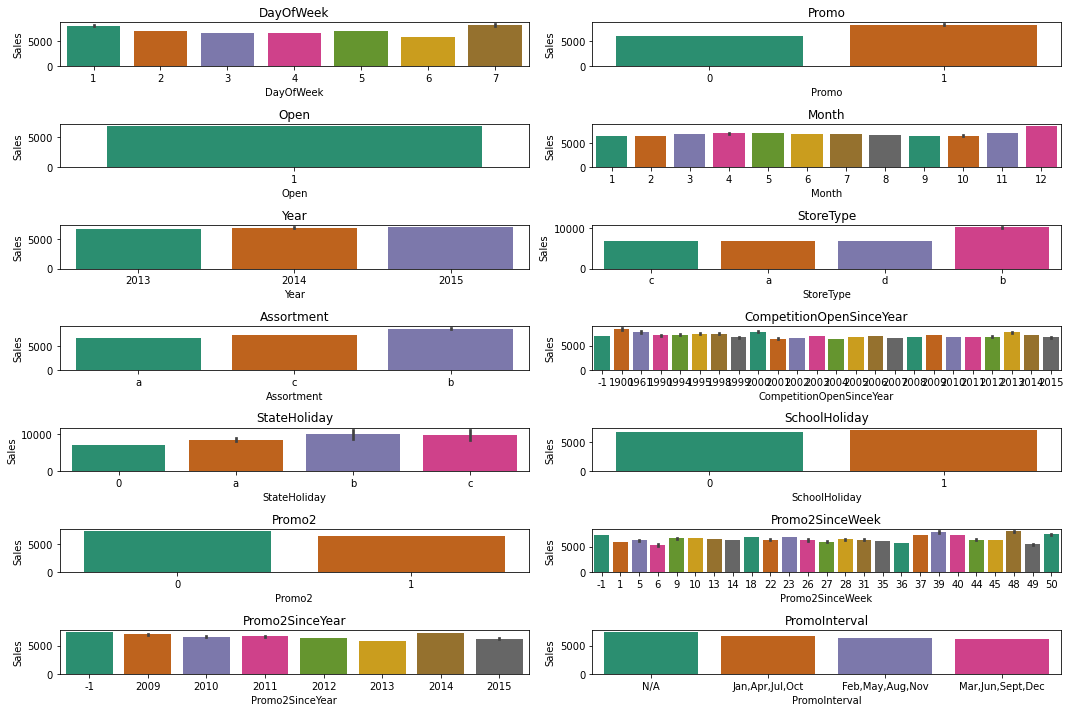

In [ ]:
# Select categorical columns
sales_categorical_cols = ['DayOfWeek', 'Promo','Open','Month' ,'Year','StoreType','Assortment', 'CompetitionOpenSinceYear', 'StateHoliday','SchoolHoliday','Promo2','Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

# Define rows and columns for subplots
rows = int(np.ceil(len(sales_categorical_cols) / 2))  # Assuming 2 columns per row
cols = min(2, len(sales_categorical_cols))

# Create figure and subplots
fig, axs = plt.subplots(rows, cols, figsize=(15, 10), squeeze=True)  # Ensure 1D array of subplots

for i, col in enumerate(sales_categorical_cols):
    sns.barplot(x=col, y='Sales', data=store_sales, ax=axs.ravel()[i], palette="Dark2")
    axs.ravel()[i].set_title(col)
    axs.ravel()[i].xaxis.set_label_text(col)  # Access and set label on the correct subplot's axis

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()


**FINDINGS**
> Almost nil sales on Sunday and high sales on Monday

> Higher sales when there is promotion

> Assortment b has higher sales

> Slight increase in sales when school holiday

> Slight increase in state holiday a,b,c

> Competition Since features show no siginificant impact on sales






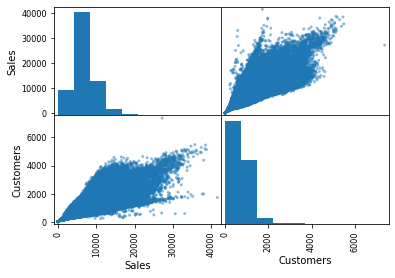

In [ ]:
#Sales_Customers

attributes = ["Sales", "Customers"]
scatter_matrix(store_sales[attributes]);

**FINDINGS**
1. Increase in customer increases sales/increase in sales increases customers.


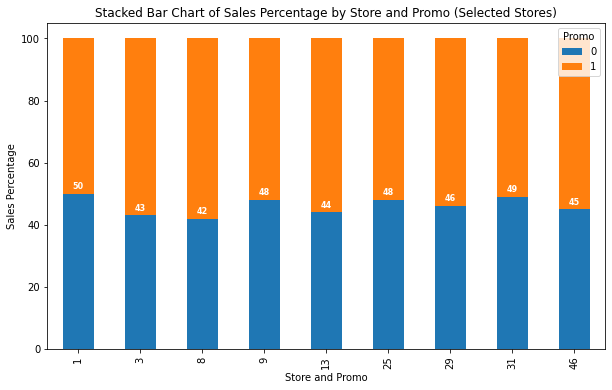

In [ ]:

# Assuming grouped_data is a DataFrame
grouped_data = store_sales.groupby(['Store', 'Promo'])['Sales'].sum().unstack()

# Filter stores
selected_stores = [1, 3, 8, 9, 13, 25, 29, 31, 46]
grouped_data = grouped_data[grouped_data.index.isin(selected_stores)]

# Calculate percentage based on the filtered grouped_data and round to 0 decimal places
percentage_data = (grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100).round(0)

# Plot the stacked bar chart
ax = percentage_data.plot(kind='bar', stacked=True, figsize=(10, 6))

# Display percentage labels on each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=8, color='white', weight='bold', padding=3)

# Set labels and title
plt.xlabel('Store and Promo')
plt.ylabel('Sales Percentage')
plt.title('Stacked Bar Chart of Sales Percentage by Store and Promo (Selected Stores)')

# Show the plot
plt.show()


**FINDINGS**

Promotion has significant impact on the key stores identified

### Check for Outliers in Sales and Customers

In [ ]:
# detecting outliers
store_sales.describe(percentiles=[0.90,0.95,0.99])

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,WeekofYear,Month
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.0,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,1.0,0.446352,0.193580,5443.847175,4.608370,1369.370279,0.498684,11.094802,1002.728749,2013.831937,23.646801,5.845738
std,321.731914,1.723689,3104.214680,401.227674,0.0,0.497114,0.395103,7804.253543,4.658448,936.023913,0.499999,15.691005,1006.374804,0.777260,14.389785,3.323931
min,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,2013.000000,1.000000,1.000000
50%,558.000000,3.000000,6369.000000,676.000000,1.0,0.000000,0.000000,2320.000000,4.000000,2006.000000,0.000000,-1.000000,-1.000000,2014.000000,23.000000,6.000000
90%,1004.000000,6.000000,10771.000000,1177.000000,1.0,1.000000,1.000000,15720.000000,11.000000,2013.000000,1.000000,40.000000,2013.000000,2015.000000,45.000000,11.000000
95%,1060.000000,6.000000,12668.000000,1440.000000,1.0,1.000000,1.000000,20390.000000,12.000000,2014.000000,1.000000,40.000000,2014.000000,2015.000000,49.000000,12.000000
99%,1104.000000,6.000000,17789.000000,2415.000000,1.0,1.000000,1.000000,36410.000000,12.000000,2015.000000,1.000000,45.000000,2014.000000,2015.000000,51.000000,12.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.0,1.000000,1.000000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000,2015.000000,52.000000,12.000000


In [ ]:
#Remove outlier sales.
store_sales_nooutlier = store_sales[store_sales['Sales'] <= store_sales['Sales'].quantile(.99)]
store_sales_nooutlier = store_sales_nooutlier[store_sales_nooutlier['Customers'] <= store_sales_nooutlier['Customers'].quantile(.99)]

### EDA on the 9 KEY stores data

In [ ]:
data_store1 = store_sales_nooutlier[(store_sales_nooutlier.Store==1)]
print('Number of records for store 1: ', len(data_store1))
data_store3 = store_sales_nooutlier[(store_sales_nooutlier.Store==3)]
print('Number of records for store 3: ', len(data_store3))
data_store8 = store_sales_nooutlier[(store_sales_nooutlier.Store==8)]
print('Number of records for store 8: ', len(data_store8))
data_store9 = store_sales_nooutlier[(store_sales_nooutlier.Store==9)]
print('Number of records for store 9: ', len(data_store9))
#
data_store13 = store_sales_nooutlier[(store_sales_nooutlier.Store==13)]
print('Number of records for store 13: ', len(data_store13))
data_store25 = store_sales_nooutlier[(store_sales_nooutlier.Store==25)]
print('Number of records for store 25: ', len(data_store25))
data_store29 = store_sales_nooutlier[(store_sales_nooutlier.Store==29)]
print('Number of records for store 29: ', len(data_store29))
data_store31 = store_sales_nooutlier[(store_sales_nooutlier.Store==31)]
print('Number of records for store 31: ', len(data_store31))
#
data_store46 = store_sales_nooutlier[(store_sales_nooutlier.Store==46)]
print('Number of records for store 46: ', len(data_store46))

store_dfs = [data_store1, data_store3, data_store8, data_store9, data_store13, data_store25, data_store29, data_store31, data_store46 ]
label_dfs = ['store1', 'store3', 'store8', 'store9', 'store13', 'store25','store29', 'store31', 'store46']
index = [1,3,8,9,13,25,29,31,46]


left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.8   # the amount of height reserved for white space between subplots


Number of records for store 1:  781
Number of records for store 3:  779
Number of records for store 8:  784
Number of records for store 9:  779
Number of records for store 13:  621
Number of records for store 25:  695
Number of records for store 29:  779
Number of records for store 31:  784
Number of records for store 46:  622


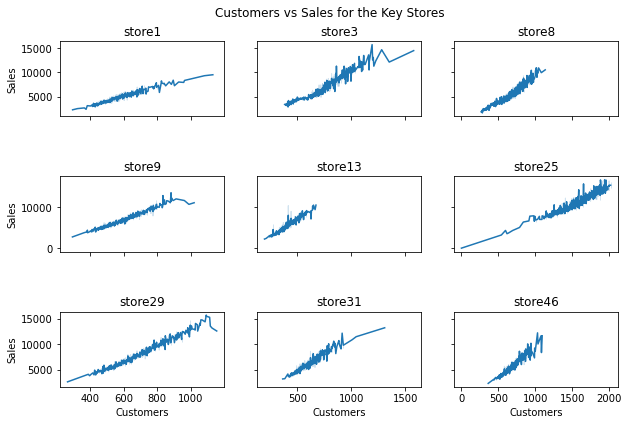

In [ ]:
plot_store_trend('Customers vs Sales for the Key Stores', 'Customers', 'Sales', 'line')

**Findings** - Increase in customer increases sales

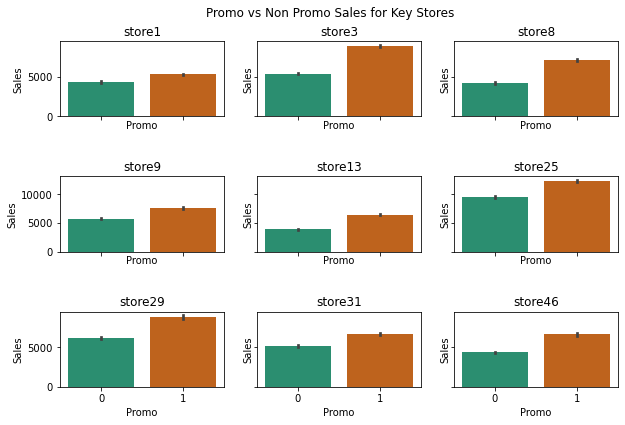

In [ ]:
plot_store_trend('Promo vs Non Promo Sales for Key Stores', 'Promo', 'Sales', 'bar')

**Findings** - PRomo has positive impact on Sales

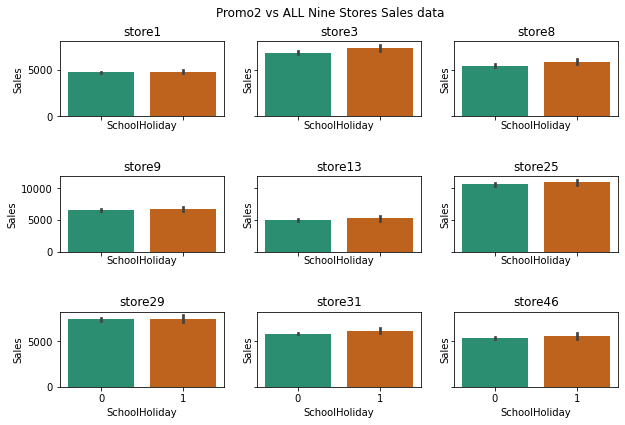

In [ ]:
plot_store_trend('Promo2 vs ALL Nine Stores Sales data', 'SchoolHoliday', 'Sales', 'bar')

**Findings ** - School holidays has marginal increase in sales.

<AxesSubplot:xlabel='Month', ylabel='Sales'>

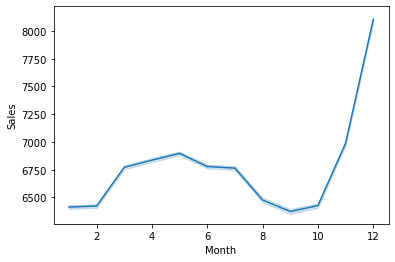

In [ ]:
 sns.lineplot(x='Month', y='Sales', data=store_sales_nooutlier, palette="Dark2")

**Findings** - Year end has significant increase in sales

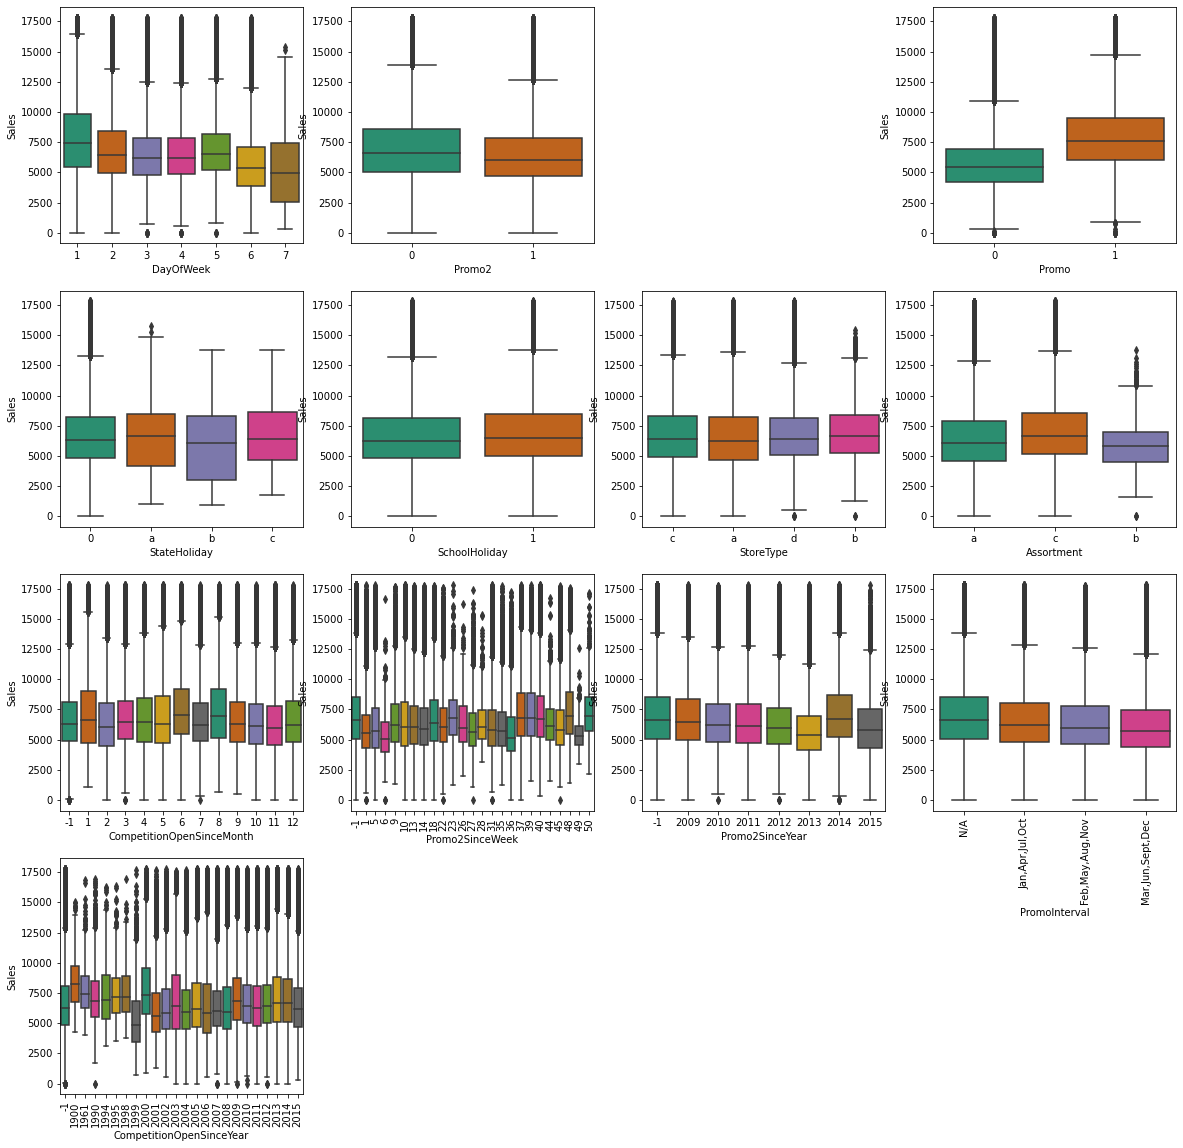

In [ ]:
# box-plot creation for variious variables w.r.t sales
plt.figure(figsize=(20,20))
plt.subplot(4,4,1)
sns.boxplot(x = store_sales_nooutlier.DayOfWeek, y = store_sales_nooutlier.Sales, palette="Dark2")

plt.subplot(4,4,2)
sns.boxplot(x = store_sales_nooutlier.Promo2, y = store_sales_nooutlier.Sales, palette="Dark2")

plt.subplot(4,4,4)
sns.boxplot(x = store_sales_nooutlier.Promo, y = store_sales_nooutlier.Sales, palette="Dark2")

plt.subplot(4,4,5)
sns.boxplot(x = store_sales_nooutlier.StateHoliday, y = store_sales_nooutlier.Sales, palette="Dark2")

plt.subplot(4,4,6)
sns.boxplot(x = store_sales_nooutlier.SchoolHoliday, y = store_sales_nooutlier.Sales, palette="Dark2")

plt.subplot(4,4,7)
sns.boxplot(x = store_sales_nooutlier.StoreType, y = store_sales_nooutlier.Sales, palette="Dark2")

plt.subplot(4,4,8)
sns.boxplot(x = store_sales_nooutlier.Assortment, y = store_sales_nooutlier.Sales, palette="Dark2")

plt.subplot(4,4,9)
sns.boxplot(x = store_sales_nooutlier.CompetitionOpenSinceMonth, y = store_sales_nooutlier.Sales, palette="Dark2")

plt.subplot(4,4,10)
sns.boxplot(x = store_sales_nooutlier.Promo2SinceWeek, y = store_sales_nooutlier.Sales, palette="Dark2")
plt.xticks(rotation=90)

plt.subplot(4,4,11)
sns.boxplot(x = store_sales_nooutlier.Promo2SinceYear, y = store_sales_nooutlier.Sales, palette="Dark2")

plt.subplot(4,4,12)
sns.boxplot(x = store_sales_nooutlier.PromoInterval, y = store_sales_nooutlier.Sales, palette="Dark2")
plt.xticks(rotation=90)

plt.subplot(4,4,13)
sns.boxplot(x = store_sales_nooutlier.CompetitionOpenSinceYear, y = store_sales_nooutlier.Sales, palette="Dark2")

plt.xticks(rotation=90)
plt.show()

Findings :
1. Sunday has no sales and Monday has increase in sales
2. StateHoliday has increase in sales
3. Promo increases sales
4. Rest of the features dont have much impact on sales

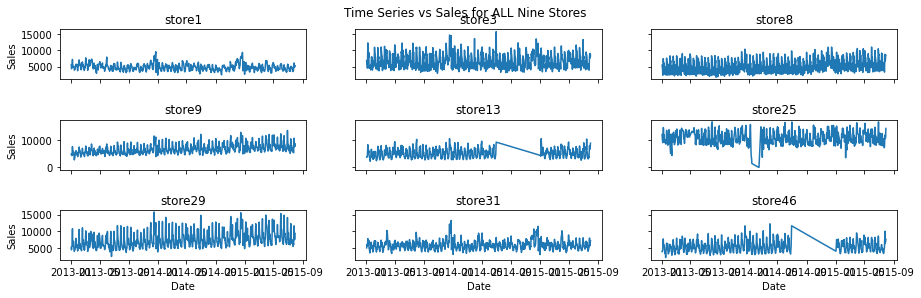

In [ ]:
# Time series with Sales

range_dict = {"0":"1", "1":"3", "2":"5"}
fig, axis = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(15,4))
fig.suptitle('Time Series vs Sales for ALL Nine Stores')
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for x in range (0,3):
    incr = range_dict[str(x)]
    for y in range (0,3):
        i = x + y + int(incr)
        label = label_dfs[i-1]
        d = store_dfs[i-1]
        #
        axis[x,y].title.set_text(label)
        sns.lineplot(x=d.Date, y='Sales', data=d, ax=axis[x,y])

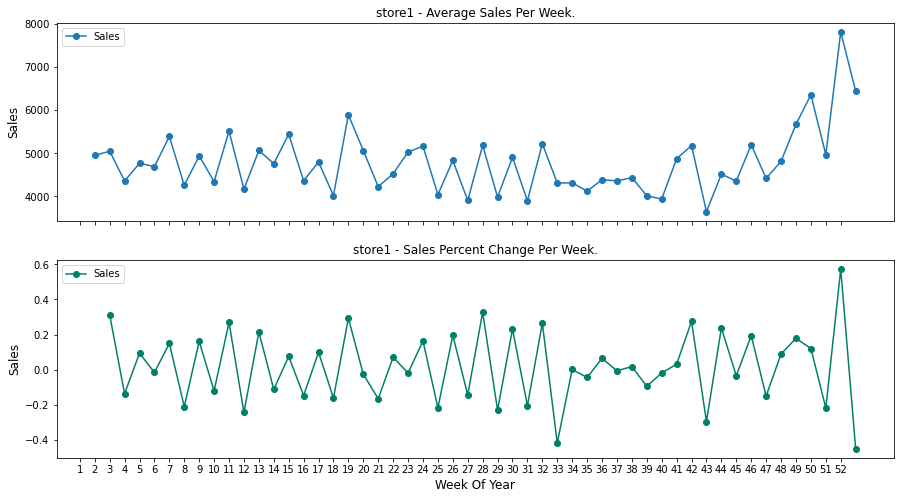

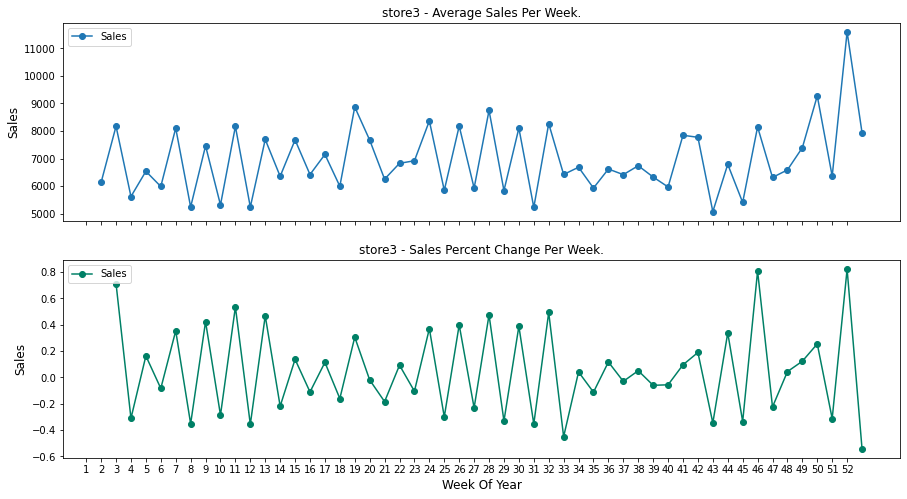

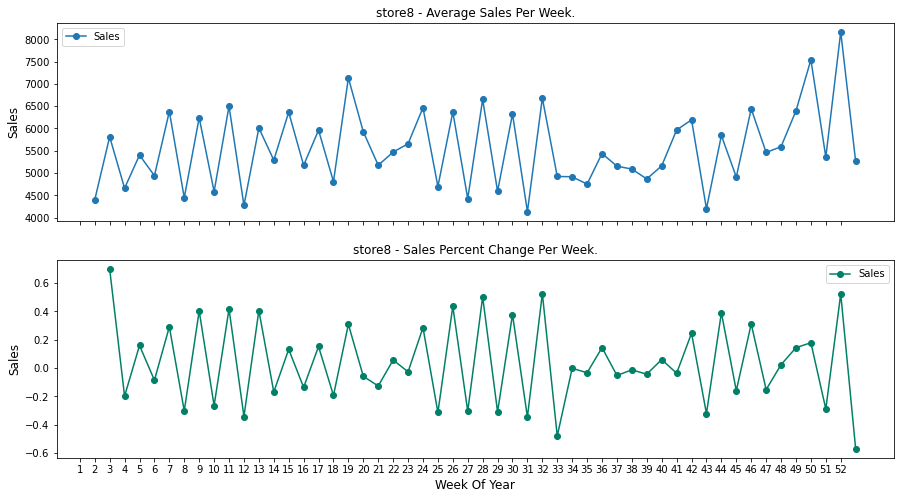

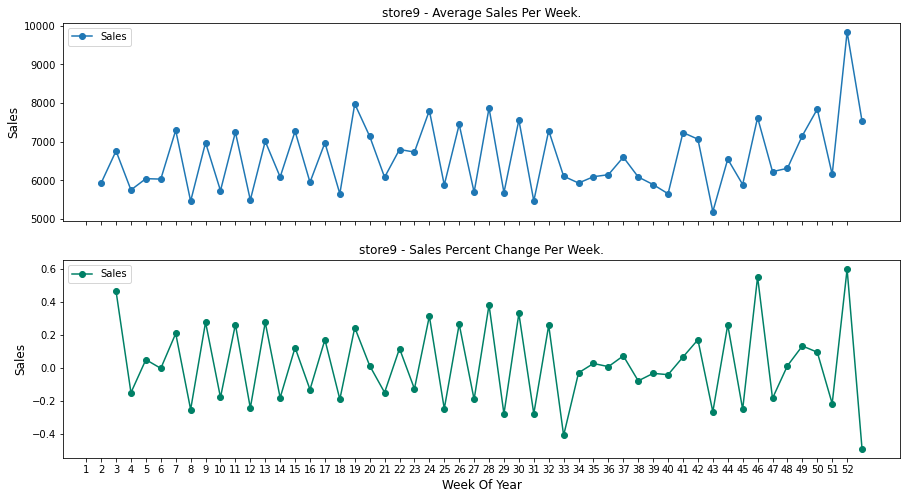

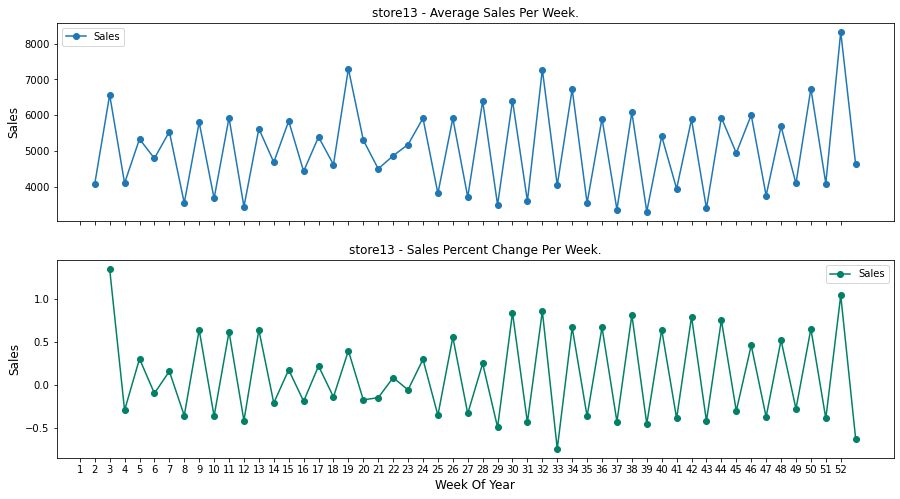

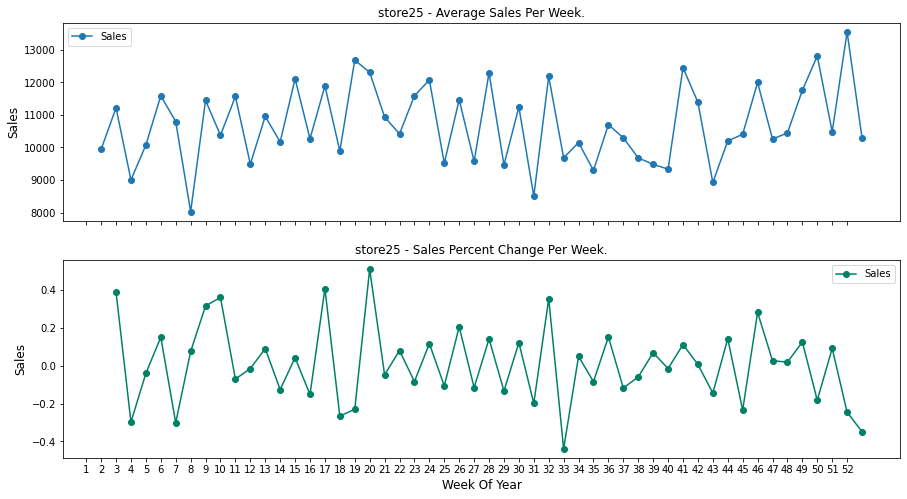

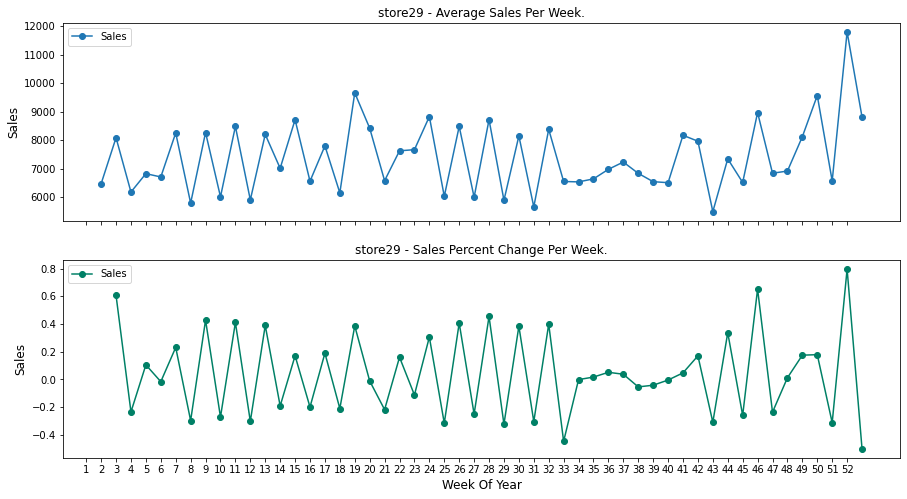

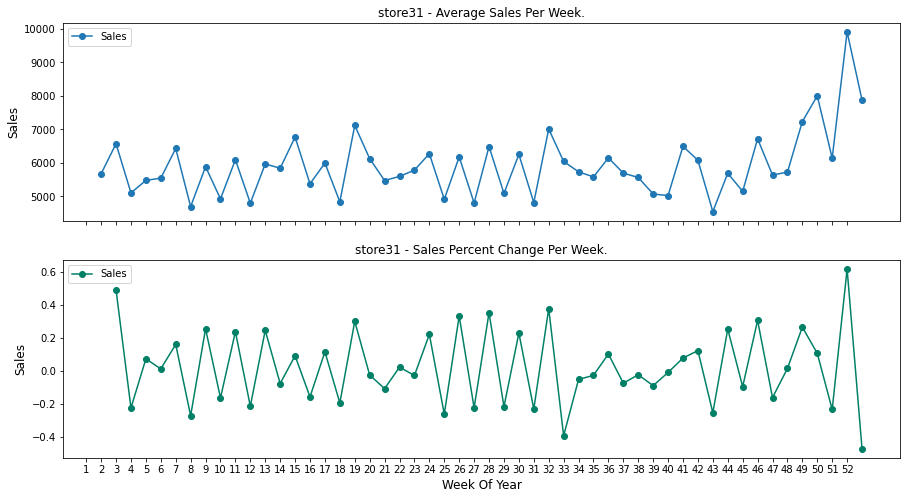

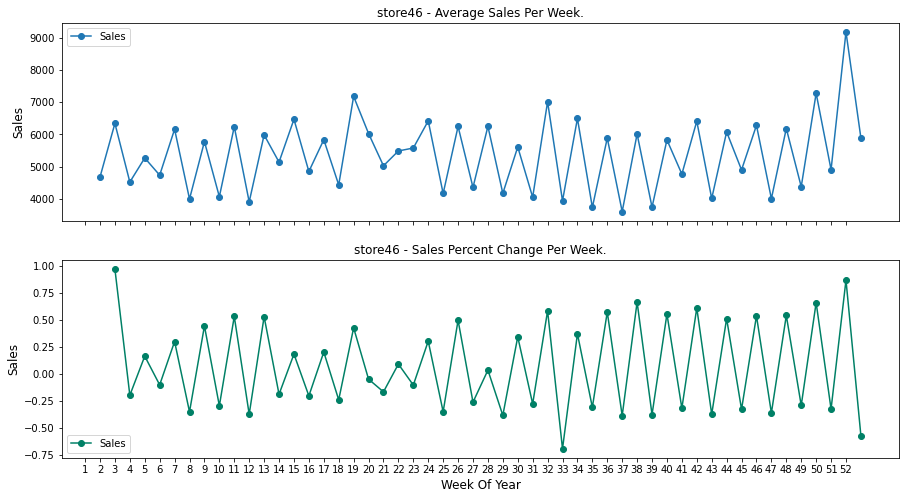

In [ ]:
# Let us plot average sales and pct change in sales
for i in range(0,9):
    d = store_dfs[i]
    label = label_dfs[i]
    # group by WeekofYear and get average sales, and precent change
    average_sales    = d.groupby('WeekofYear')["Sales"].mean()
    pct_change_sales = d.groupby('WeekofYear')["Sales"].sum().pct_change()

    fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

    # plot average sales over time(year-month)
    ax1 = average_sales.plot(legend=True, ax=axis1, marker='o', title=label + " - Average Sales Per Week.")
    ax1.set_xticks(range(len(average_sales)))
    ax1.set_xticklabels(average_sales.index.tolist())
    ax1.set_ylabel('Sales', size=12)

    # plot precent change for sales over time(year-month)
    ax2 = pct_change_sales.plot(legend=True, ax=axis2, marker='o', colormap="summer", title=label + " - Sales Percent Change Per Week.")
    plt.ylabel("Sales", size=12)
    plt.xlabel('Week Of Year', size=12)

Findings - Year end week 52 has increase in sales. It is also interesting to note that Christmas and New Year(see graph at weeks near 52) lead to increase in sales across all stores.

### FEATURE ENGINEERING

In [ ]:
dummy_dow = pd.get_dummies(store_sales_nooutlier.DayOfWeek, drop_first=True, prefix= 'DayOfWeek')
dummy_dow.head(2)

,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,0,0,0,1,0,0
1,0,0,0,1,0,0


In [ ]:
dummy_sh = pd.get_dummies(store_sales_nooutlier.StateHoliday, drop_first=True, prefix='StateHoliday')
dummy_sh.head(2)

,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,0,0,0
1,0,0,0


In [ ]:
#merging the dummies
store_sales_merged = pd.concat([store_sales_nooutlier, dummy_dow, dummy_sh], axis=1)

In [ ]:
store_sales_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 827603 entries, 0 to 1017190
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      827603 non-null  int64         
 1   DayOfWeek                  827603 non-null  int64         
 2   Date                       827603 non-null  datetime64[ns]
 3   Sales                      827603 non-null  int64         
 4   Customers                  827603 non-null  int64         
 5   Open                       827603 non-null  int64         
 6   Promo                      827603 non-null  int64         
 7   StateHoliday               827603 non-null  object        
 8   SchoolHoliday              827603 non-null  int64         
 9   StoreType                  827603 non-null  object        
 10  Assortment                 827603 non-null  object        
 11  CompetitionDistance        827603 non-null  int64  

In [ ]:
# Retain only the necessary columns going forward
store_sales_merged.drop(columns=['CompetitionOpenSinceYear','DayOfWeek','WeekofYear', 'Open','Month',
                           'PromoInterval','Promo2SinceYear','Promo2SinceWeek','Month','Year',
                           'Promo2','CompetitionDistance','Assortment','StoreType','StateHoliday',
                            'CompetitionOpenSinceMonth'],inplace=True)

In [ ]:
store_sales_merged.head(5)

,Store,Date,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,1,2015-07-31,5263,555,1,1,0,0,0,1,0,0,0,0,0
1,2,2015-07-31,6064,625,1,1,0,0,0,1,0,0,0,0,0
2,3,2015-07-31,8314,821,1,1,0,0,0,1,0,0,0,0,0
3,4,2015-07-31,13995,1498,1,1,0,0,0,1,0,0,0,0,0
4,5,2015-07-31,4822,559,1,1,0,0,0,1,0,0,0,0,0


In [ ]:

# Set 'Date' column as the index
store_sales_merged.set_index('Date', inplace=True)

 **Model Scope:**
 The scope has been kept to nine key stores across Europe. These stores are numbered - 1,3,8,9,13,25,29,31 and 46. We will build model to predict overall average sales for all these key stores.

In [ ]:
key_stores = [1,3,8,9,13,25,29,21,46]
keystore_sales = store_sales_merged[store_sales_merged['Store'].isin(key_stores)]

In [ ]:
# aggrigating the data for model building
store_sales_grouped = keystore_sales.groupby(['Date']).agg({'Sales': 'mean',
                                           'Customers':'mean',
                                           'Promo': 'sum',
                                           'SchoolHoliday': 'sum',
                                           'DayOfWeek_2':'mean',
                                           'DayOfWeek_3':'mean',
                                           'DayOfWeek_4':'mean',
                                           'DayOfWeek_5':'mean',
                                           'DayOfWeek_6':'mean',
                                           'DayOfWeek_7':'mean',
                                           'StateHoliday_a':'mean',
                                           'StateHoliday_b':'mean',
                                           'StateHoliday_c':'mean',})
store_sales_grouped.head(2)

,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StateHoliday_a,StateHoliday_b,StateHoliday_c
Date,,,,,,,,,,,,,
2013-01-02,5702.333333,688.0,0,9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,5162.444444,636.0,0,9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Resample to fill missing dates and interpolate values
store_sales_resampled = store_sales_grouped.resample('D').mean().interpolate()

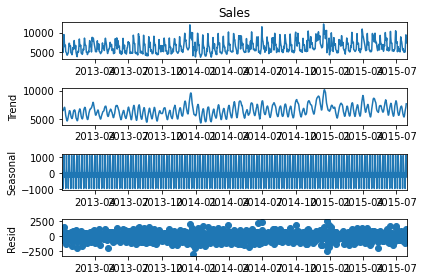

In [ ]:
# Time series Decomposition

# seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(store_sales_resampled.Sales, model='additive')
fig = decomposition.plot()
plt.show()

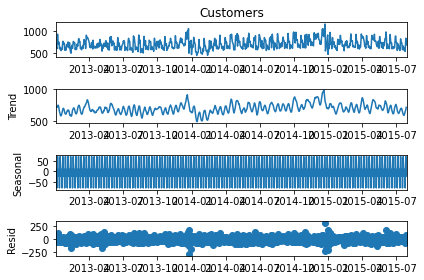

In [ ]:
# Time series Decomposition
# seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(store_sales_resampled.Customers, model='additive')
fig = decomposition.plot()
plt.show()

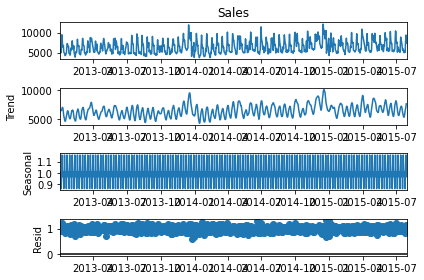

In [ ]:
# seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(store_sales_resampled.Sales, model='multiplicative')
fig = decomposition.plot()
plt.show()

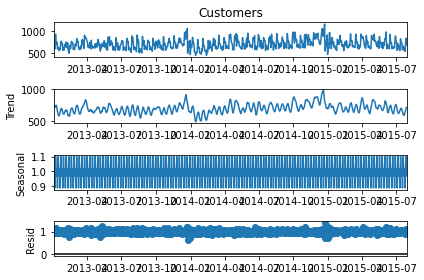

In [ ]:
# seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(store_sales_resampled.Customers, model='multiplicative')
fig = decomposition.plot()
plt.show()

***FINDINGS***

There are variability in Seasonal & Residual; Howerver these follow consistent pattern. Dec sees spike in sales

In [ ]:
store_sales_grouped.head()

,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StateHoliday_a,StateHoliday_b,StateHoliday_c
Date,,,,,,,,,,,,,
2013-01-02,5702.333333,688.000000,0,9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,5162.444444,636.000000,0,9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-04,5221.777778,635.666667,0,9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2013-01-05,4981.000000,592.111111,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-07,9481.777778,922.111111,9,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
store_sales_grouped.shape[0]

784

Stationarity Test

In [ ]:
# Apply tests to each column
sales_stationary = adf_test(store_sales_grouped['Sales'], 'Sales')
customers_stationary = adf_test(store_sales_grouped['Customers'], 'Customers')
# Apply tests to each column
sales_stationary = kpss_test(store_sales_grouped['Sales'], 'Sales')
customers_stationary = kpss_test(store_sales_grouped['Customers'], 'Customers')

ADF Test for Sales:
ADF Statistic: -4.324372531493527
p-value: 0.0004029682946354119
Critical Values: {'1%': -3.438915730045254, '5%': -2.8653205426302253, '10%': -2.5687831424305845}
Is Stationary: True

ADF Test for Customers:
ADF Statistic: -4.430878210664364
p-value: 0.00026162921661943163
Critical Values: {'1%': -3.4388710830827125, '5%': -2.8653008652386576, '10%': -2.568772659807725}
Is Stationary: True

KPSS Test for Sales:
KPSS Statistic: 2.2128794158050544
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Is Stationary: False

KPSS Test for Customers:
KPSS Statistic: 1.3425521517544168
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Is Stationary: False



FINDINGS
Condradicting results so lets plot the data and check visually to confirm

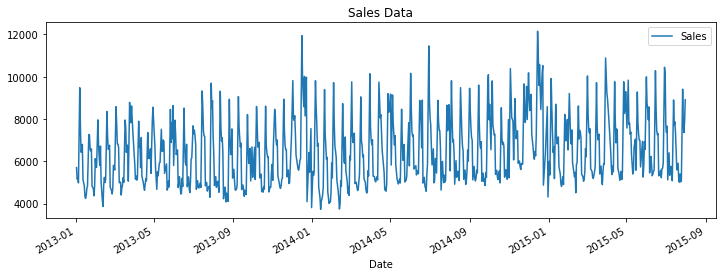

In [ ]:
store_sales_grouped['Sales'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Sales Data')
plt.show(block=False)

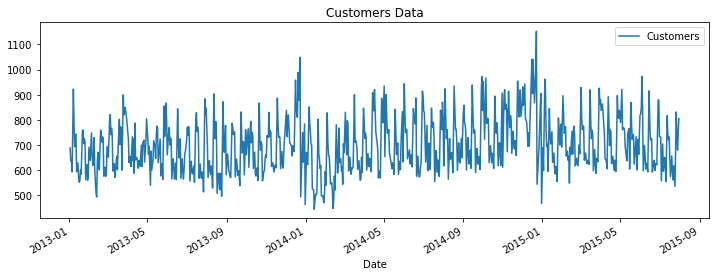

In [ ]:
store_sales_grouped['Customers'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Customers Data')
plt.show(block=False)

Visually it looks stationary but condracting results in statistical test. In another of the implementation tried to differene but the results of the model didnt look promising.

In [ ]:
# ADF and KPSS are giving contradicting results. So, difference as recommended in this article https://medium.com/@tannyasharma21/comparision-study-of-adf-vs-kpss-test-c9d8dec4f62a .
# Results by differncing didnt look promising
# # Perform differencing on both 'Sales' and 'Customers' columns
# store_sales_grouped['Sales_diff'] = store_sales_grouped['Sales'].diff()
# store_sales_grouped['Customers_diff'] = store_sales_grouped['Customers'].diff()

# # Drop NaN values generated by differencing (since the first value has no previous value to subtract)
# store_sales_grouped = store_sales_grouped.dropna()

#Johansen test for co integration came to be 2 when differencing

CO INTEGRATION TEST

The Granger causality test assesses whether past values of one time series help predict another time series. The null hypothesis is that the lagged values of the first time series do not provide significant information in predicting the second time series.

In [ ]:
causality_sales=grangercausalitytests(store_sales_grouped[['Sales','Customers']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=46.3741 , p=0.0000  , df_denom=780, df_num=1
ssr based chi2 test:   chi2=46.5525 , p=0.0000  , df=1
likelihood ratio test: chi2=45.2211 , p=0.0000  , df=1
parameter F test:         F=46.3741 , p=0.0000  , df_denom=780, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=25.3323 , p=0.0000  , df_denom=777, df_num=2
ssr based chi2 test:   chi2=50.9907 , p=0.0000  , df=2
likelihood ratio test: chi2=49.3972 , p=0.0000  , df=2
parameter F test:         F=25.3323 , p=0.0000  , df_denom=777, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=24.0398 , p=0.0000  , df_denom=774, df_num=3
ssr based chi2 test:   chi2=72.7717 , p=0.0000  , df=3
likelihood ratio test: chi2=69.5782 , p=0.0000  , df=3
parameter F test:         F=24.0398 , p=0.0000  , df_denom=774, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=14.4883 , p=0.0000  

If the p-value is below a chosen significance level (e.g., 0.05), it suggests evidence against the null hypothesis. The test indicates casuality between Sales and customers

ACF and PCF to find p and Q

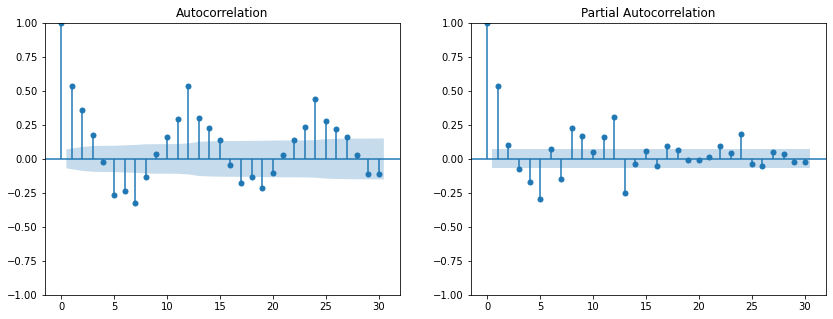

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
sm.graphics.tsa.plot_acf(store_sales_grouped['Sales'].squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(store_sales_grouped['Sales'].squeeze(), lags=30, ax=ax[1])

plt.show()
#q=0 and q=7

#### INTERPRETATION OF P and Q FROM PLOT
ACF : q = 1, 7, 12

PCF : p = 1, 5, 12

CO INTEGRATION TEST 2

In [ ]:
endog_vars = ['Sales', 'Customers']
exog_vars = ['Promo','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7','SchoolHoliday']

In [ ]:
"""
    Johansen cointegration test of the cointegration rank of a VECM

    Parameters
    ----------
    endog : array_like (nobs_tot x neqs)
        Data to test
    det_order : int
        * -1 - no deterministic terms - model1
        * 0 - constant term - model3
        * 1 - linear trend
    k_ar_diff : int, nonnegative
        Number of lagged differences in the model.
"""

def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [ ]:
joh_model1 = coint_johansen(store_sales_grouped[endog_vars],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    154.641098  155.980771
1      1.339673    1.339673 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [ ]:
rank=select_coint_rank(store_sales_grouped[endog_vars],-1,1)
print(rank.rank)

1


***FINDINGS***

The endo vars - Sales and Customers are co integrated

In [ ]:
min_date = store_sales_grouped.index.min()
max_date = store_sales_grouped.index.max()

print(min_date, max_date)

#Sunday closed - 6 weeks * 7 days = 42 days
prior_date = max_date - timedelta(days=42)

print(min_date, max_date, prior_date)

2013-01-02 00:00:00 2015-07-31 00:00:00
2013-01-02 00:00:00 2015-07-31 00:00:00 2015-06-19 00:00:00


In [ ]:
#Fill missing dates with mean
idx = pd.date_range(store_sales_grouped.index.min(),store_sales_grouped.index.max())
store_sales_rnd = store_sales_grouped.reindex(idx)
store_sales_rnd = store_sales_rnd.fillna(store_sales_rnd.mean())

#### Train / Test Split


In [ ]:
#train = store_sales_grouped[store_sales_grouped.index < prior_date]
#test = store_sales_grouped[store_sales_grouped.index >= prior_date]
train = store_sales_rnd[store_sales_rnd.index < prior_date]
test = store_sales_rnd[store_sales_rnd.index >= prior_date]

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 898 entries, 2013-01-02 to 2015-06-18
Freq: D
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sales           898 non-null    float64
 1   Customers       898 non-null    float64
 2   Promo           898 non-null    float64
 3   SchoolHoliday   898 non-null    float64
 4   DayOfWeek_2     898 non-null    float64
 5   DayOfWeek_3     898 non-null    float64
 6   DayOfWeek_4     898 non-null    float64
 7   DayOfWeek_5     898 non-null    float64
 8   DayOfWeek_6     898 non-null    float64
 9   DayOfWeek_7     898 non-null    float64
 10  StateHoliday_a  898 non-null    float64
 11  StateHoliday_b  898 non-null    float64
 12  StateHoliday_c  898 non-null    float64
dtypes: float64(13)
memory usage: 98.2 KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43 entries, 2015-06-19 to 2015-07-31
Freq: D
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sales           43 non-null     float64
 1   Customers       43 non-null     float64
 2   Promo           43 non-null     float64
 3   SchoolHoliday   43 non-null     float64
 4   DayOfWeek_2     43 non-null     float64
 5   DayOfWeek_3     43 non-null     float64
 6   DayOfWeek_4     43 non-null     float64
 7   DayOfWeek_5     43 non-null     float64
 8   DayOfWeek_6     43 non-null     float64
 9   DayOfWeek_7     43 non-null     float64
 10  StateHoliday_a  43 non-null     float64
 11  StateHoliday_b  43 non-null     float64
 12  StateHoliday_c  43 non-null     float64
dtypes: float64(13)
memory usage: 4.7 KB


In [ ]:
test_len = test.shape[0]

In [ ]:

#Fit transform on train data
#scaler = MinMaxScaler()
#train[['Sales','Customers','Promo','SchoolHoliday']]=scaler.fit_transform(train[['Sales','Customers','Promo','SchoolHoliday']])
#train.head()

In [ ]:
#Transform on test data

#test[['Sales','Customers','Promo','SchoolHoliday']]=scaler.transform(test[['Sales','Customers','Promo','SchoolHoliday']])
#test.head()

#Standardising the values is affecting the model performance poorly. Below is the result if standarised.
#0	VAR	Sales	0.16	31.87
#1	VAR	Customers	0.11	28.26

In [ ]:
# Assuming you have 'exog' and 'endog' DataFrames
exog = train[['Promo', 'SchoolHoliday', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']].astype(float)
endog = train[['Sales', 'Customers']].astype(float)

##V**AR (Vector Auto Regressive) Model**

In [ ]:
# replace with values identified from ACF and PCF plot
p_values_list = [1, 5, 12]
q_values_list = [1, 7, 12]

best_aic = float("inf")
best_order = None

# Loop through all combinations of 'p' and 'q'
for p_value in p_values_list:
    for q_value in q_values_list:
        order_params = (p_value, q_value)
        mod = sm.tsa.VARMAX(train[endog_vars], order=order_params, trend='n')
        try:
            res = mod.fit(maxiter=1000, disp=False)
            current_aic = res.aic
            if current_aic < best_aic:
                best_aic = current_aic
                best_order = order_params
        except Exception as e:
            print(f"Issue with order {order_params}: {e}")

# Fit the VARMAX model with the best order parameters
best_mod = sm.tsa.VARMAX(train[endog_vars], order=best_order, trend='n')
best_res = best_mod.fit(maxiter=1000, disp=False)

# Print the summary of the best-fitted model
print(best_res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  898
Model:                        VARMA(12,7)   Log Likelihood              -11627.387
Date:                    Wed, 28 Feb 2024   AIC                          23412.774
Time:                            12:27:21   BIC                          23791.988
Sample:                        01-02-2013   HQIC                         23557.652
                             - 06-18-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.01, 0.38   Jarque-Bera (JB):       195.94, 618.36
Prob(Q):                        0.92, 0.54   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.79, 1.27   Skew:                       0.55, 0.01
Prob(H) (two-sided):            0.00, 0.04   Kurtosis:                   5.01, 7.07


In [ ]:
predictions = best_res.forecast(steps=test_len)
predictions['Date'] = test.index
predictions = predictions.set_index('Date')

In [ ]:
# If we had differenced the values then we need to invert differencing when getting actual results. Since we didnt difference this is not required anymore.
# # Forecast on the test set
# test_len = len(test)
# predictions_diff = best_res.get_forecast(steps=test_len).predicted_mean
# # Invert differencing to get actual predictions
# predicted_sales = predictions_diff['Sales_diff'].shift(1).cumsum() + train['Sales'].iloc[-1]
# predicted_customers = predictions_diff['Customers_diff'].shift(1).cumsum() + train['Customers'].iloc[-1]

# # Use backward fill to replace NaN values
# predicted_sales = predicted_sales.bfill()
# predicted_customers = predicted_customers.bfill()

# # Add the predictions to the original DataFrame
# predictions = pd.DataFrame({'Sales': predicted_sales, 'Customers': predicted_customers}, index=test.index)

# # Print or display the results
# print(predictions)

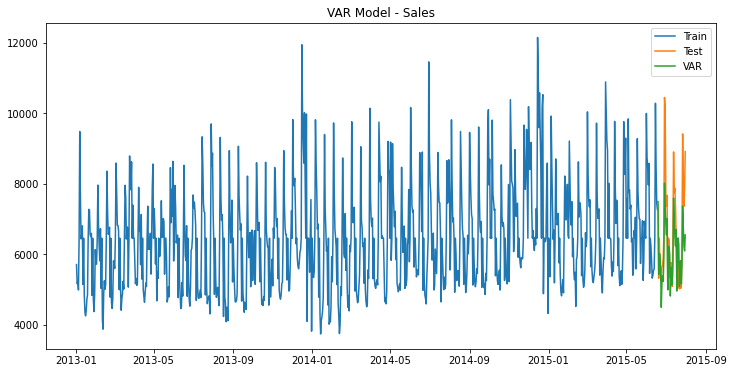

In [ ]:
plot_time_series(train, test, predictions, 'Sales', 'VAR')

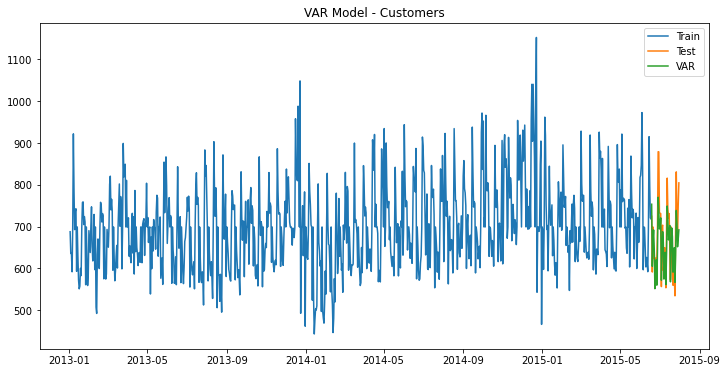

In [ ]:
plot_time_series(train, test, predictions, 'Customers', 'VAR')

In [ ]:
model_comparison = pd.DataFrame()

model_comparison = add_to_model_comparison(model_comparison, 'VAR', 'Sales', test.Sales, predictions.Sales)
model_comparison = add_to_model_comparison(model_comparison, 'VAR', 'Customers', test.Customers, predictions.Customers)

display(model_comparison)

,Model,Variable,RMSE,MAPE
0,VAR,Sales,1012.02,10.61
1,VAR,Customers,55.33,6.61


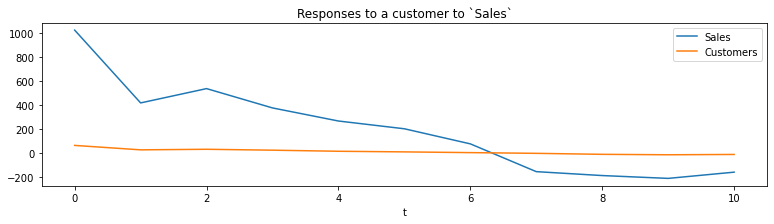

In [ ]:
ax = best_res.impulse_responses(10, orthogonalized=True).plot(figsize=(13,3))
ax.set(xlabel='t', title='Responses to a customer to `Sales`');

## **VARMAX**

In [ ]:
# replace with values identified from ACF and PCF plot
p_values_list = [1, 5, 12]
q_values_list = [1, 7, 12]

best_aic = float("inf")
best_order = None

# Loop through all combinations of 'p' and 'q'
for p_value in p_values_list:
    for q_value in q_values_list:
        order_params = (p_value, q_value)
        mod = sm.tsa.VARMAX(train[endog_vars], order=order_params, trend='n', exog=train[exog_vars])
        try:
            res = mod.fit(maxiter=1000, disp=False)
            current_aic = res.aic
            if current_aic < best_aic:
                best_aic = current_aic
                best_order = order_params
        except Exception as e:
            print(f"Issue with order {order_params}: {e}")

# Fit VARMAX model with optimal parameters
mod_vm = sm.tsa.VARMAX(train[endog_vars], order=best_order, trend='n', exog=train[exog_vars])
res_vm = mod_vm.fit(maxiter=1000, disp=False)
print(res_vm.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  898
Model:                       VARMAX(12,1)   Log Likelihood              -11883.388
Date:                    Wed, 28 Feb 2024   AIC                          23908.775
Time:                            13:11:42   BIC                          24249.587
Sample:                        01-02-2013   HQIC                         24038.982
                             - 06-18-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.01, 2.14   Jarque-Bera (JB):      406.71, 2736.28
Prob(Q):                        0.92, 0.14   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.63, 1.42   Skew:                      1.06, -1.65
Prob(H) (two-sided):            0.00, 0.00   Kurtosis:                  5.52, 10.89


In [ ]:
predictions_vm = res_vm.forecast(steps=test_len, exog=test[exog_vars])
predictions_vm['Date'] = test.index
predictions_vm = predictions_vm.set_index('Date')

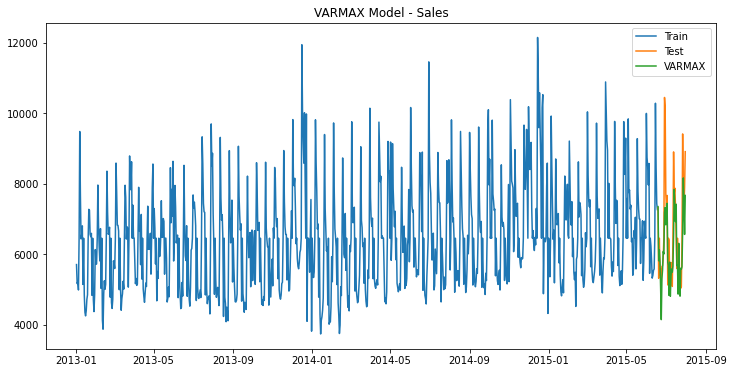

In [ ]:
plot_time_series(train, test, predictions_vm, 'Sales', 'VARMAX')

In [ ]:
model_comparison = add_to_model_comparison(model_comparison, 'VARMAX', 'Sales', test.Sales, predictions_vm.Sales)
model_comparison = add_to_model_comparison(model_comparison, 'VARMAX', 'Customers', test.Customers, predictions_vm.Customers)

display(model_comparison)

,Model,Variable,RMSE,MAPE
0,VAR,Sales,1012.02,10.61
1,VAR,Customers,55.33,6.61
2,VARMAX,Sales,1073.23,10.80
3,VARMAX,Customers,86.38,10.36


impulse response graph involves understanding how the variables in a system react over time to a shock or impulse in one of the variables.

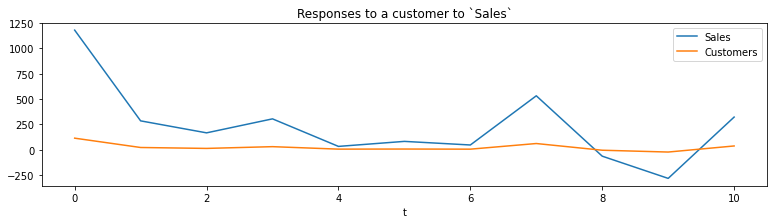

In [ ]:
ax = res_vm.impulse_responses(10, orthogonalized=True).plot(figsize=(13,3))
ax.set(xlabel='t', title='Responses to a customer to `Sales`');

## **SARIMAX**

In [ ]:
# Perform hyperparameter tuning for Sales
model_sales = pm.auto_arima(train['Sales'], exogenous=train[exog_vars], seasonal=True, m=12)
results_sales = sm.tsa.statespace.SARIMAX(train['Sales'], order=model_sales.order, seasonal_order=model_sales.seasonal_order, exog=train[exog_vars]).fit()

print("Sales Model Parameters:")
print(results_sales.params)

# Perform hyperparameter tuning for Customers
model_customers = pm.auto_arima(train['Customers'], exogenous=train[exog_vars], seasonal=True, m=12)
results_customers = sm.tsa.statespace.SARIMAX(train['Customers'], order=model_customers.order, seasonal_order=model_customers.seasonal_order, exog=train[exog_vars]).fit()

print("Customers Model Parameters:")
print(results_customers.params)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.17539D+00    |proj g|=  5.23456D-01


 This problem is unconstrained.



At iterate    5    f=  7.99250D+00    |proj g|=  1.92759D-02

At iterate   10    f=  7.98712D+00    |proj g|=  2.96183D-03

At iterate   15    f=  7.98568D+00    |proj g|=  7.64794D-03

At iterate   20    f=  7.98495D+00    |proj g|=  7.27528D-03

At iterate   25    f=  7.98420D+00    |proj g|=  2.84793D-03

At iterate   30    f=  7.98419D+00    |proj g|=  7.51999D-05

At iterate   35    f=  7.98419D+00    |proj g|=  1.28722D-03

At iterate   40    f=  7.98393D+00    |proj g|=  1.22398D-02

At iterate   45    f=  7.98368D+00    |proj g|=  4.87007D-04

At iterate   50    f=  7.98368D+00    |proj g|=  3.39278D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.51846D+00    |proj g|=  1.85314D-01

At iterate   10    f=  5.49915D+00    |proj g|=  3.99135D-02

At iterate   15    f=  5.49483D+00    |proj g|=  6.80657D-02

At iterate   20    f=  5.49122D+00    |proj g|=  3.13235D-02

At iterate   25    f=  5.49055D+00    |proj g|=  4.24012D-02

At iterate   30    f=  5.48973D+00    |proj g|=  1.13563D-02

At iterate   35    f=  5.48741D+00    |proj g|=  1.12947D-02

At iterate   40    f=  5.48731D+00    |proj g|=  1.45133D-02

At iterate   45    f=  5.48642D+00    |proj g|=  1.45807D-02

At iterate   50    f=  5.48597D+00    |proj g|=  5.08199D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [ ]:
#Testing the fitted model.
predictions_sm_sales = results_sales.predict(start=test.index.min(),end=test.index.max(), exog=test[exog_vars],dynamic=True)
#Testing the fitted model.
predictions_sm_customers = results_customers.predict(start=test.index.min(),end=test.index.max(), exog=test[exog_vars],dynamic=True)


# Creating DataFrame for predictions
df_predictions = pd.DataFrame({
    'Sales': predictions_sm_sales,
    'Customers': predictions_sm_customers
}, index=test.index)

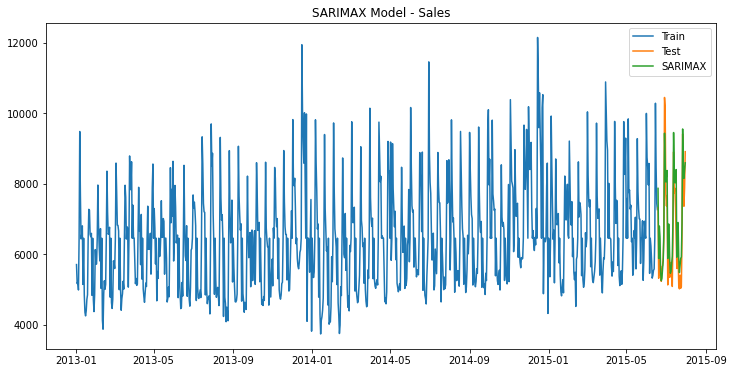

In [ ]:
plot_time_series(train, test, df_predictions, 'Sales', 'SARIMAX')

In [ ]:

model_comparison = add_to_model_comparison(model_comparison, 'SARIMAX', 'Sales', test.Sales, df_predictions.Sales)
model_comparison = add_to_model_comparison(model_comparison, 'SARIMAX', 'Customers', test.Customers, df_predictions.Customers)

display(model_comparison)

,Model,Variable,RMSE,MAPE
0,VAR,Sales,1012.02,10.61
1,VAR,Customers,55.33,6.61
2,VARMAX,Sales,1073.23,10.80
3,VARMAX,Customers,86.38,10.36
4,SARIMAX,Sales,683.06,8.52
5,SARIMAX,Customers,52.85,6.37


After comparing VARMA, VARMAX, and SARIMAX models, SARIMAX emerged as the top performer for predicting aggregated sales across nine key stores.

When transitioning to individual store-level predictions, adopting a hierarchical forecasting approach becomes valuable. Hierarchical forecasting involves defining the hierarchy structure, aggregating data at each level, applying appropriate time series models, forecasting bottom-up, ensuring consistency, and evaluating/refining the system. This method allows for accurate sales predictions at various organizational levels, accommodating specific forecasting needs for different branches or products within an organization.


In [ ]:
#Display predictions for the 6 weeks
df_predictions

,Sales,Customers
2015-06-19,7866.972491,774.046587
2015-06-20,5875.088692,616.037936
2015-06-21,6797.531438,699.866118
2015-06-22,6491.387030,686.853719
2015-06-23,5489.692111,619.947007
2015-06-24,5243.339720,591.264374
2015-06-25,5314.412254,634.499874
2015-06-26,5581.444667,631.371349
2015-06-27,5816.858252,607.027602
2015-06-28,6672.851507,668.713741
